<a href="https://colab.research.google.com/github/vachaconcu/Mineriadatos/blob/master/Raza_Primera_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Resnet para clasificación de Raza

En el código siguiente se importan las funciones necesarias, principalmente de tensorflow.keras

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os


Ahora se importan los datos que ya están en forma de tensores y separados en datos de entrenamiento, validación interna y validación externa.

Los datos de etiqueta ya se encuentran en codificación one-hot donde los niveles de raza son: Blanco [10000], Negro [01000], Asiático [00100], Indio [00010], Otro [00001].



In [ ]:
import os
os.chdir('/content/drive/My Drive/Minería de Datos/Interna/datos')

datos= load('/content/drive/My Drive/Minería de Datos/Interna/datos/X_R_val_int.npz') ; x_test = datos['arr_0']
datos= load('/content/drive/My Drive/Minería de Datos/Interna/datos/X_R_train.npz') ; x_train = datos['arr_0']
datos= load('/content/drive/My Drive/Minería de Datos/Interna/datos/y_R_val_int.npz') ; y_test = datos['arr_0']
datos= load('/content/drive/My Drive/Minería de Datos/Interna/datos/y_R_train.npz') ; y_train = datos['arr_0']

datos= load('/content/drive/My Drive/Mineria/Interna/datos/y_R_val_ext.npz') ; y_test2 = datos['arr_0']
datos= load('/content/drive/My Drive/Mineria/Interna/datos/X_R_val_ext.npz') ; x_test2 = datos['arr_0']

Se imprimen los tamaños de los conjuntos de datos correspondientes:

In [ ]:
print('x_test =',x_test.shape)
print('x_train =',x_train.shape)
print('y_test =',y_test.shape)
print('y_train =',y_train.shape)

print('y_test_ext=', y_test2.shape)
print('x_test_ext=', x_test2.shape)

x_test = (1719, 200, 200, 3)
x_train = (6874, 200, 200, 3)
y_test = (1719, 5)
y_train = (6874, 5)
y_test_ext= (2063, 5)
x_test_ext= (2063, 200, 200, 3)


El número de clases se establece como 5 ya que las clasificaciones posibles son Blanco, Negro, Asiático, Indio y otro.

In [ ]:
batch_size = 32 
epochs = 85

data_augmentation = True
num_classes = 5
subtract_pixel_mean = True

n = 2
version = 2

if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

model_type = 'ResNet%dv%d' % (depth, version)
model_type

'ResNet20v2'

Se establece el tamaño de entrada como 200x200x3 y se realiza el centrado de las imágenes.

In [ ]:
input_shape = x_train.shape[1:]

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (6874, 200, 200, 3)
6874 train samples
1719 test samples
y_train shape: (6874, 5)



Se programa el valor de la tasa de aprendizaje, ya que si se usa un tamaño de epoch muy grande, esta se haga más pequeña.

In [ ]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 dropout=0.3,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
            x = Dropout(dropout)(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
            x = Dropout(dropout)(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v2(input_shape, depth, num_classes=5, dropout=0.3):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 110 in [b])')
    
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)
    inputs = Input(shape=input_shape)
    
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                
                if res_block == 0:  
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                
                if res_block == 0:
                    
                    strides = 2 

           
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])

        num_filters_in = num_filters_out

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
plot_model(model, to_file="%s.png" % model_type, show_shapes=True)
print(model_type)

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 200, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 200, 200, 16) 0           batch_normalization[0][0]        
________________________________________________________________________

In [ ]:
save_dir = os.path.join(os.getcwd(), './Modelos')
model_name = 'Raza_0.3_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    
    datagen = ImageDataGenerator(
        
        featurewise_center=False,
        
        samplewise_center=False,
        
        featurewise_std_normalization=False,
        
        samplewise_std_normalization=False,
        
        zca_whitening=False,
        
        rotation_range=0,
        
        width_shift_range=0.1,
        
        height_shift_range=0.1,
        
        horizontal_flip=True,
        
        vertical_flip=False)

    
    datagen.fit(x_train)

    
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, 
                        steps_per_epoch=len(x_train)//batch_size,
                        callbacks=callbacks)

Using real-time data augmentation.
Learning rate:  0.001
Epoch 1/85
214/214 [==============================] - ETA: 0s - loss: 1.8575 - accuracy: 0.4702
Epoch 00001: val_accuracy improved from -inf to 0.46888, saving model to /content/drive/My Drive/Minería de Datos/Interna/datos/./Modelos/Raza_0.3_ResNet20v2_model.001.h5
214/214 [==============================] - 225s 1s/step - loss: 1.8575 - accuracy: 0.4702 - val_loss: 1.6910 - val_accuracy: 0.4689 - lr: 0.0010
Learning rate:  0.001
Epoch 2/85
214/214 [==============================] - ETA: 0s - loss: 1.5815 - accuracy: 0.5330
Epoch 00002: val_accuracy improved from 0.46888 to 0.61082, saving model to /content/drive/My Drive/Minería de Datos/Interna/datos/./Modelos/Raza_0.3_ResNet20v2_model.002.h5
214/214 [==============================] - 221s 1s/step - loss: 1.5815 - accuracy: 0.5330 - val_loss: 1.3981 - val_accuracy: 0.6108 - lr: 0.0010
Learning rate:  0.001
Epoch 3/85
214/214 [==============================] - ETA: 0s - loss: 

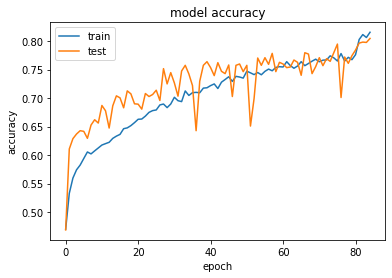

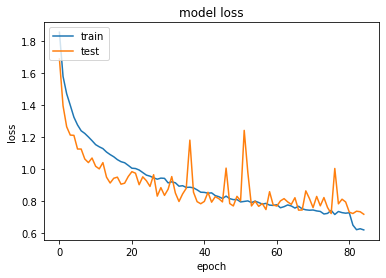

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()